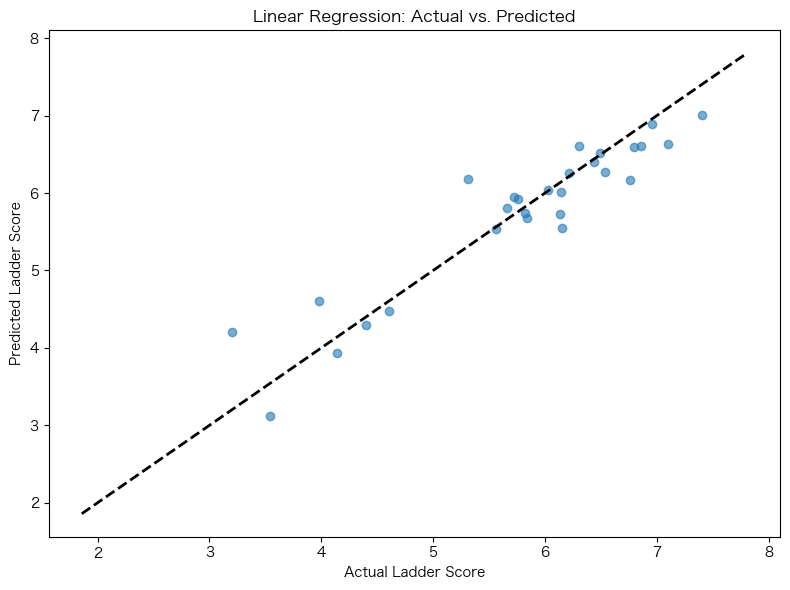

Random Forest RMSE: 0.4295, R2: 0.8411
Cross-validation RMSE: 0.5579 (+/- 0.1650)


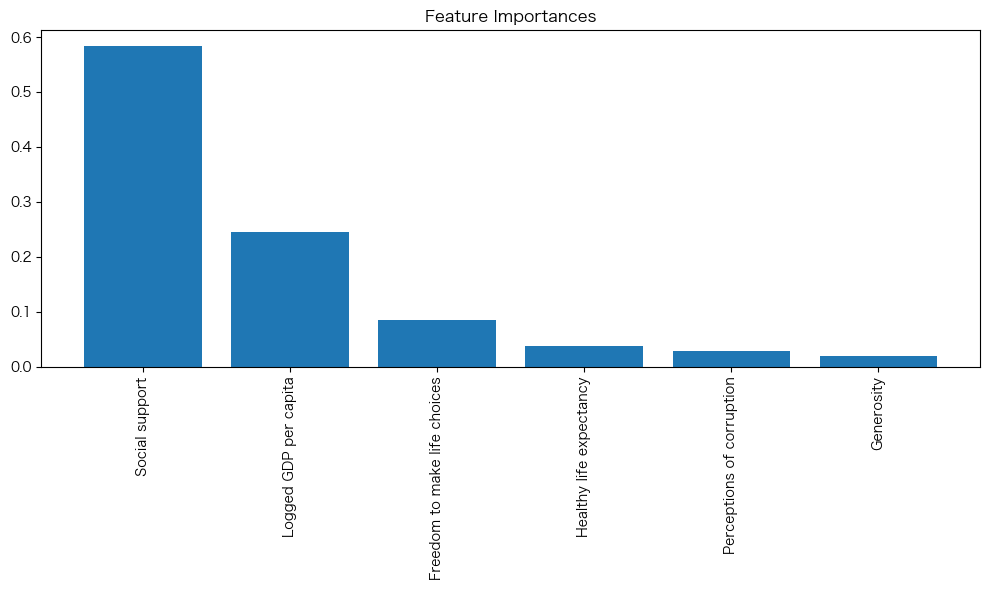

Gradient Boosting RMSE: 0.4710, R2: 0.8089
Cross-validation RMSE: 0.5981 (+/- 0.1829)


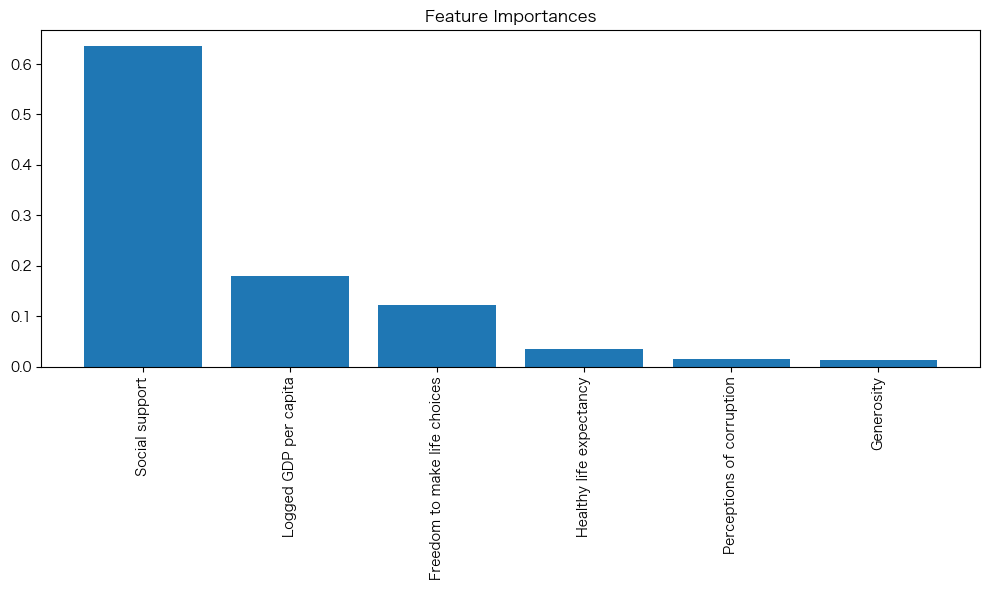

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 108, number of used features: 6
[LightGBM] [Info] Start training from score 5.483306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

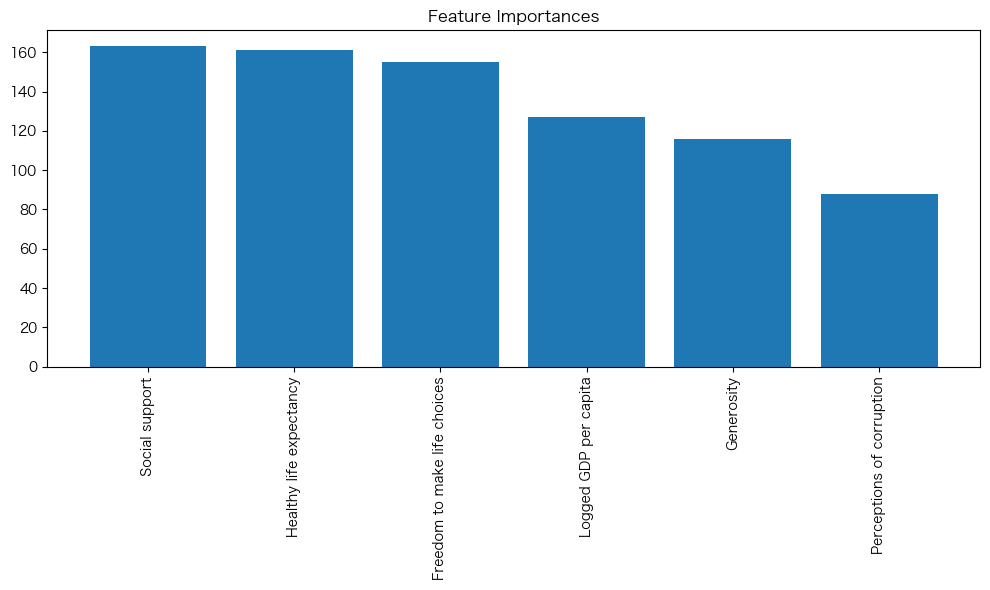

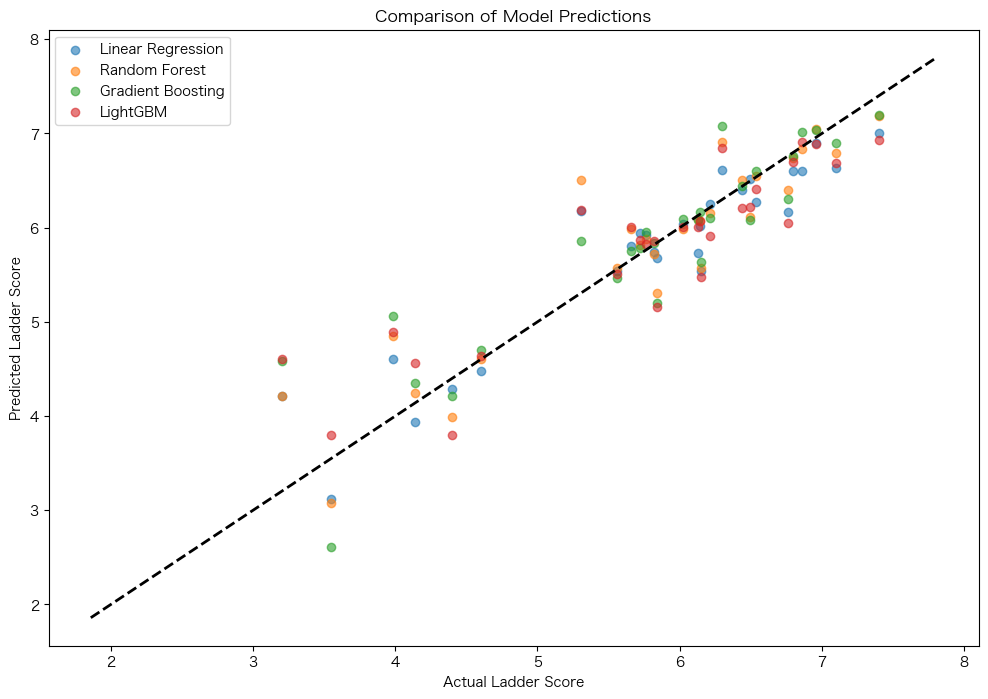

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import warnings

# 警告の抑制
warnings.filterwarnings("ignore", category=FutureWarning)

# 日本語フォントの設定
mpl.rcParams['font.family'] = 'Hiragino Sans GB'

# データの読み込み
url = '/Users/madoka/trantura_ondisk/practice/randam_forest/WHR2023 2.csv'
data = pd.read_csv(url)
data.head()

# 必要な列を選択
columns = ['Country name', 'Ladder score', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
data = data[columns]

# 欠損値の処理
data.dropna(inplace=True)

# 特徴量とターゲットの分離
X = data.drop(['Country name', 'Ladder score'], axis=1)
y = data['Ladder score']

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# モデル評価関数
def evaluate_model(y_true, y_pred, model_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return rmse, r2

# クロスバリデーション関数
def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"Cross-validation RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")

# 特徴量重要度のプロット関数
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# 線形回帰モデルの予測結果の可視化
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Ladder Score')
plt.ylabel('Predicted Ladder Score')
plt.title('Linear Regression: Actual vs. Predicted')
plt.tight_layout()
plt.show()
# ランダムフォレストモデル
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_rf_pred = rf_model.predict(X_test_scaled)
evaluate_model(y_test, y_rf_pred, "Random Forest")
cross_validate_model(rf_model, X_train_scaled, y_train)
plot_feature_importance(rf_model, X.columns)

# Gradient Boosting モデル
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_gb_pred = gb_model.predict(X_test_scaled)
evaluate_model(y_test, y_gb_pred, "Gradient Boosting")
cross_validate_model(gb_model, X_train_scaled, y_train)
plot_feature_importance(gb_model, X.columns)

# LightGBM モデル
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=5,
    random_state=42
)
lgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=0)]
)
y_lgb_pred = lgb_model.predict(X_test_scaled)
evaluate_model(y_test, y_lgb_pred, "LightGBM")
cross_validate_model(lgb_model, X_train_scaled, y_train)
plot_feature_importance(lgb_model, X.columns)


# 可視化: 各モデルの予測結果を比較
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, label='Linear Regression', alpha=0.6)
plt.scatter(y_test, y_rf_pred, label='Random Forest', alpha=0.6)
plt.scatter(y_test, y_gb_pred, label='Gradient Boosting', alpha=0.6)
plt.scatter(y_test, y_lgb_pred, label='LightGBM', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Ladder Score')
plt.ylabel('Predicted Ladder Score')
plt.title('Comparison of Model Predictions')
plt.legend()
plt.show()

In [9]:
data = pd.read_csv(url)
data.head()
data.shape


(137, 19)